# Calculations of latent heat

Latent heat is typically not measured directly but instead computed from bulk formulae.  The current standard method is using the COARE Bulk Flux Algorithm (see Fairall, C.W., E. F. Bradley, J. E. Hare, A. A. Grachev, and J. B. Edson, 2003: Bulk Parameterization of Air-Sea Fluxes: Updates and Verification for the COARE Algorithm. J. Climate, 16, pp 571-591).

The code for the CBA is avaible in different places, mostly in Matlab and FORTRAN (https://www.pmel.noaa.gov/ocs/flux-documentation).  Here we use a python package for CBA-3.6 (see for example coare_bulk_flux.ipynb).

There are a few representations of latent heat flux around, but the basic equation is:

\begin{eqnarray}
Q_{E} = \rho_{air} L_{v} E
\end{eqnarray}

where $\rho_{air}$ is the density of air, $L_{v}$ is the latent heat of vaporization and $E$ is evaporation.

## Air density

The density of air is given by

\begin{equation}
  \rho_{air} = \frac{100 \: P_{atm}} {R_{gas} \: [T_{air}+273.16][1+0.61 \: q_{10}]}
\end{equation}

where $P_{atm}$ is atmospheric pressure (mb), $T_{air}$ is air temperature ($^{\circ}C$), $R_{gas}$ is a constant (287.1), and $q_{10}$ is the specific humidity at 10 $m$ (g/kg).  The first two are typically measured, while the last can be computed from the (measured) relative humidity, $R_{h}$, temperature and pressure.  First, the saturation vapor pressure is computed as:

\begin{equation}
  e_{s} = 6.1121 \: e^{\left( \frac{17.502 \: T_{air}}{240.97 + T_{air}} \right) } \left(1.0007 + 3.46 x 10^{-6} \: P_{atm} \right)
\end{equation}

and then

\begin{equation}
  q_{10} = \frac{ 6.22 \: R_{h} \: e_{s} } { P_{atm} - 3.78 x 10^{-3} \: R_{h} \: e_{s} }
\end{equation}

## Latent heat of vaporization

When a material in liquid state is given energy, it changes its phase from liquid to vapor; the energy absorbed in this process is called the heat of vaporization. The latent heat of vaporization of seawater is usually taken as a constant, typically something like 2,453,000 $J/kg$.  It can also be computed from (ocean surface) temperature ($T_{SST}$) and salinity ($S$) as follows:

\begin{equation}
  L_{v} = \left( 2.5008991412 x 10^{6} - 2.3691806479 x 10^{3} \:T_{SST} + 2.6776439436 x 10^{-1} \: T_{SST}^{2}
        - 8.1027544602 x 10^{-3} \: T_{SST}^{3} - 2.0799346624 x 10^{-5} \: T_{SST}^{4} \right) 
        \left(1.0 - 0.001 \:S \right)
\end{equation}

This equation is then (usually) simplified further as in the case of CBA-3.6:

\begin{equation}
  L_{v} = [ 2.501 - 0.00237 \: T_{SST} ] x 10^{6}
\end{equation}

## Evaporation

The calculation of evaporation is a little more complex, and it is computed as the product of the friction velocity ($u^{*}$) and specific humidity factor ($q^{*}$).  The complication comes in as these parameters require adjustment from the observation (sensor) level to a standard level, and thus vertical stability functions ($\psi_{u}$ and $\psi_{q}$) and roughness numbers ($z_{\circ}$ is the roughness length, and $r_{T}$ and $r_{q}$ are the lower boundary limits of the logarithmic profiles of temperature and specific humidity from the roughness Reynolds number).

\begin{equation}
  q_{*} = \frac {q_{10} - q_{ss}}
                    {2.2 \left[ ln ( \frac{z_{q} u_{*}}
                                {r_{q} \nu_{air}}) - \psi_{q} \right] 1.5}
\end{equation}

\begin{equation}
  u_{*} = \frac {0.4
                \left[ u_{air}^{2} + u_{gust}^{2} \right]^{\frac{1}{2}}}
                    {ln ( \frac{z_{u}}{z_{\circ}} ) - \psi_{u}}
\end{equation}

Finally,
\begin{equation}
  E = u^{*} \: q^{*}
\end{equation}


# COARE parameterizations

We can now look at how the COARE bulk flux algorithm computes these quantities.  It requires as input the following:

| Variable                                             | C4 Name |
|:-----------------------------------------------------|:-------:|
| relative wind speed (m/s) at height zu(m)            | u       | 
| bulk air temperature (degC) at height zt(m)          | t       |
| relative humidity (#) at height zq(m) [0-100]        | rh      |
| surface air pressure (mb) (default = 1015)           | P       |
| water temperature (degC) see jcool below             | ts      |
| downward shortwave radiation (W/m^2) (default = 150) | Rs      | 
| downward longwave radiation (W/m^2) (default = 370)  | Rl      | 
| latitude (default = +45 N)                           | lat     | 
| PBL height (m) (default = 600m)                      | zi      | 
| wind speed measurement height (m)                    | zu      | 
| air T measurement height (m)                         | zt      | 
| air q measurement height (m)                         | zq      |

In [1]:
# turn off warnings
import warnings; warnings.simplefilter('ignore')

# external packages
import numpy as np
import sys
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt

# internal packages
sys.path.insert(1, './coare')
from coare4 import coare4

## 1. Example with scalar values

In [2]:
wind_speed = np.array([20.0])
wind_sensor_hgt = np.array([2.0])
Tair = np.array([18.0])
air_sensor_hgt = np.array([2.0])
rel_humid = np.array([80.0])
humid_sensor_hgt = np.array([2.0])
pressure = np.array([1011.0])
Tocean = np.array([19.0])

lat = np.array([20.0])
pbl_height = np.array([600.0])

# not used for evap, but needed for CBA
shortwave = np.array([400.0])
longwave = np.array([100.0])

In [3]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

In [4]:
print('Air density: ', res['rhoa'])
print('Latent heat of vaporization: ', res['Le'])
print('Evaporation: ', -1.0*res['qsr']*res['usr'])
print('Latent heat flux: ', res['hlb'])

Air density:  [1.20192285]
Latent heat of vaporization:  [2455970.]
Evaporation:  [0.10841234554491133]
Latent heat flux:  [320.0209358025362]


## 2.  Latent heat dependency on different parameters

In [27]:
# Here we experiment by fixing all variables except one, and see the impact

# wind speed varies from 0 to 20 m/s (roughly 0 to 45 kts)
wind_speed = np.arange(0.0, 20.0, 0.1)

# note here we have to have all the rest as arrays, but with a single, constant value
nt = len(wind_speed)
wind_sensor_hgt = np.full( nt, 2.0 )
Tair = np.full( nt, 18.0 )
air_sensor_hgt = np.full( nt, 2.0 )
rel_humid = np.full( nt, 80.0 )
humid_sensor_hgt = np.full( nt, 2.0 )
pressure = np.full( nt, 1011.0 )
Tocean = np.full( nt, 19.0 )

lat = np.full( nt, 20.0 )
pbl_height = np.full( nt, 600.0 )

# not used for evap, but needed for CBA
shortwave = np.full( nt, 400.0 )
longwave = np.full( nt, 100.0 )

In [28]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

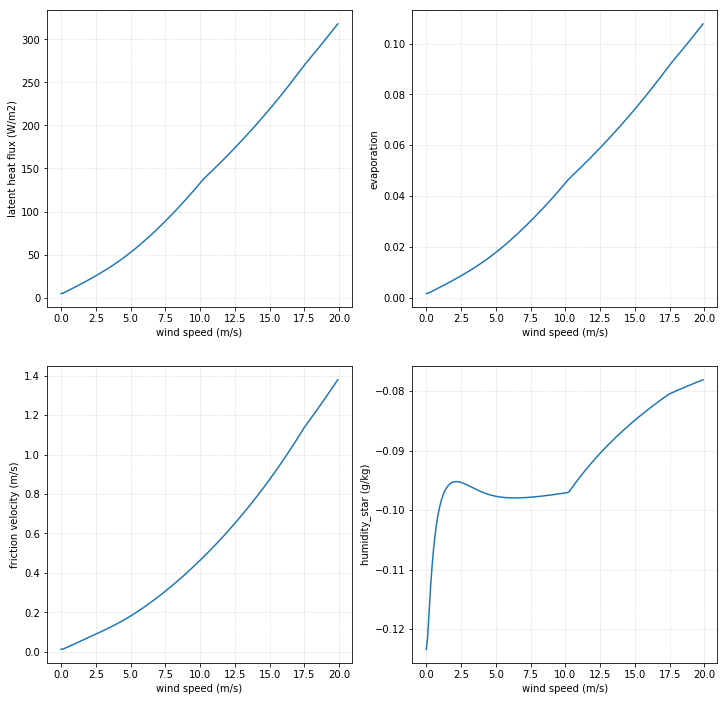

In [29]:
# make a plot
fig, ax = plt.subplots( figsize = ( 12, 12 ), nrows = 2, ncols = 2 )

ax[0,0].plot(wind_speed,res['hlb'])
ax[0,0].set_xlabel('wind speed (m/s)')
ax[0,0].set_ylabel('latent heat flux (W/m2)')
ax[0,0].grid(linestyle=':', linewidth=0.5)

ax[0,1].plot(wind_speed,-1*res['usr']*res['qsr'])
ax[0,1].set_xlabel('wind speed (m/s)')
ax[0,1].set_ylabel('evaporation')
ax[0,1].grid(linestyle=':', linewidth=0.5)

ax[1,0].plot(wind_speed,res['usr'])
ax[1,0].set_xlabel('wind speed (m/s)')
ax[1,0].set_ylabel('friction velocity (m/s)')
ax[1,0].grid(linestyle=':', linewidth=0.5)

ax[1,1].plot(wind_speed,res['qsr'])
ax[1,1].set_xlabel('wind speed (m/s)')
ax[1,1].set_ylabel('humidity_star (g/kg)')
ax[1,1].grid(linestyle=':', linewidth=0.5)

In [30]:
# relative humidity varies from 10% to 90%
rel_humid = np.arange(10.0, 90.0, 1.0 )

# note here we have to have all the rest as arrays, but with a single, constant value
nt = len(rel_humid)
wind_speed = np.full( nt, 8.0 )
wind_sensor_hgt = np.full( nt, 2.0 )
Tair = np.full( nt, 18.0 )
air_sensor_hgt = np.full( nt, 2.0 )
humid_sensor_hgt = np.full( nt, 2.0 )
pressure = np.full( nt, 1011.0 )
Tocean = np.full( nt, 19.0 )

lat = np.full( nt, 20.0 )
pbl_height = np.full( nt, 600.0 )

# not used for evap, but needed for CBA
shortwave = np.full( nt, 400.0 )
longwave = np.full( nt, 100.0 )

In [31]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

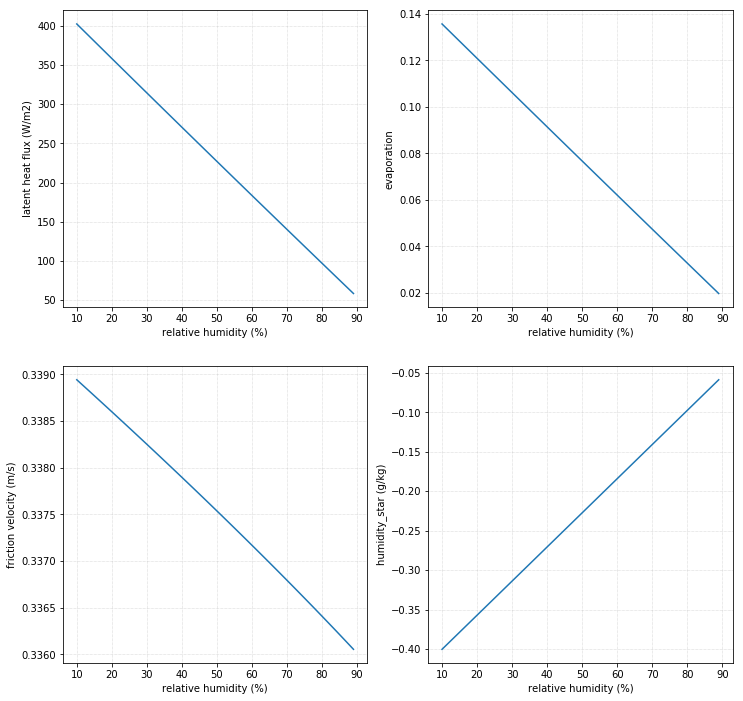

In [32]:
# make a plot
fig, ax = plt.subplots( figsize = ( 12, 12 ), nrows = 2, ncols = 2 )

ax[0,0].plot(rel_humid,res['hlb'])
ax[0,0].set_xlabel('relative humidity (%)')
ax[0,0].set_ylabel('latent heat flux (W/m2)')
ax[0,0].grid(linestyle=':', linewidth=0.5)

ax[0,1].plot(rel_humid,-1*res['usr']*res['qsr'])
ax[0,1].set_xlabel('relative humidity (%)')
ax[0,1].set_ylabel('evaporation')
ax[0,1].grid(linestyle=':', linewidth=0.5)

ax[1,0].plot(rel_humid,res['usr'])
ax[1,0].set_xlabel('relative humidity (%)')
ax[1,0].set_ylabel('friction velocity (m/s)')
ax[1,0].grid(linestyle=':', linewidth=0.5)

ax[1,1].plot(rel_humid,res['qsr'])
ax[1,1].set_xlabel('relative humidity (%)')
ax[1,1].set_ylabel('humidity_star (g/kg)')
ax[1,1].grid(linestyle=':', linewidth=0.5)

In [3]:
# relative humidity varies from 10% to 90%
Tocean = np.arange(10.0,30.0,0.1)
Tair = Tocean - 1.0

# note here we have to have all the rest as arrays, but with a single, constant value
nt = len(Tocean)
wind_speed = np.full( nt, 8.0 )
wind_sensor_hgt = np.full( nt, 2.0 )
rel_humid = np.full( nt, 80.0 )
air_sensor_hgt = np.full( nt, 2.0 )
humid_sensor_hgt = np.full( nt, 2.0 )
pressure = np.full( nt, 1011.0 )

lat = np.full( nt, 20.0 )
pbl_height = np.full( nt, 600.0 )

# not used for evap, but needed for CBA
shortwave = np.full( nt, 400.0 )
longwave = np.full( nt, 100.0 )

In [4]:
# add all the input into a dictionary and call CBA
inputs = {'u':wind_speed,'zu':wind_sensor_hgt,'t':Tair,'zt':air_sensor_hgt,
          'rh':rel_humid,'zq':humid_sensor_hgt,'P':pressure,'ts':Tocean,
          'Rs':shortwave,'Rl':longwave,'lat':lat,'zi':pbl_height}
res = coare4(inputs)

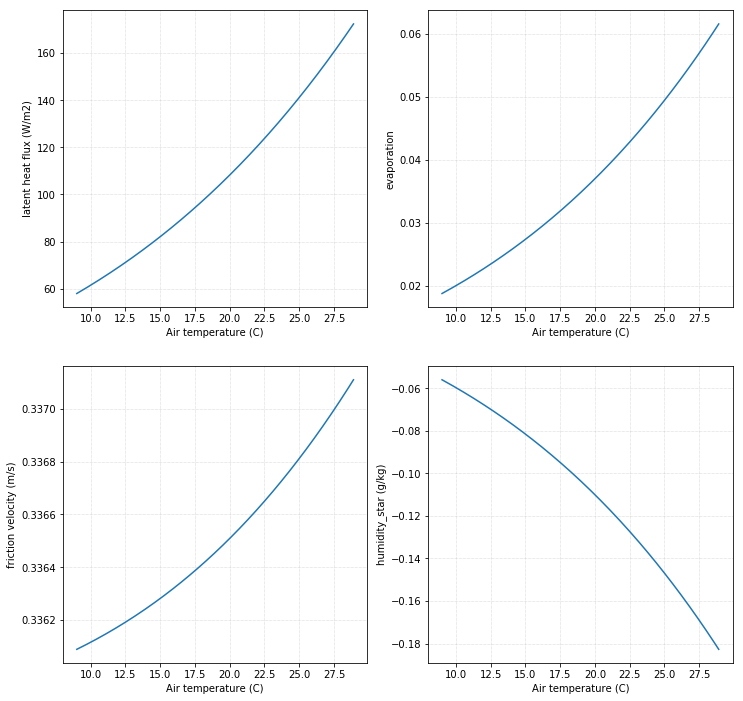

In [5]:
# make a plot
fig, ax = plt.subplots( figsize = ( 12, 12 ), nrows = 2, ncols = 2 )

ax[0,0].plot(Tair,res['hlb'])
ax[0,0].set_xlabel('Air temperature (C)')
ax[0,0].set_ylabel('latent heat flux (W/m2)')
ax[0,0].grid(linestyle=':', linewidth=0.5)

ax[0,1].plot(Tair,-1*res['usr']*res['qsr'])
ax[0,1].set_xlabel('Air temperature (C)')
ax[0,1].set_ylabel('evaporation')
ax[0,1].grid(linestyle=':', linewidth=0.5)

ax[1,0].plot(Tair,res['usr'])
ax[1,0].set_xlabel('Air temperature (C)')
ax[1,0].set_ylabel('friction velocity (m/s)')
ax[1,0].grid(linestyle=':', linewidth=0.5)

ax[1,1].plot(Tair,res['qsr'])
ax[1,1].set_xlabel('Air temperature (C)')
ax[1,1].set_ylabel('humidity_star (g/kg)')
ax[1,1].grid(linestyle=':', linewidth=0.5)

In [2]:
# Read model output and observations from ORS

In [3]:
site = 'WHOTS'
lat = 22.7667
lon = -157.8983
#site = 'NTAS'
#site = 'Stratus'